In [2]:
import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
corpus_raw = 'He is the king . The king is royal . She is the royal  queen '
# convert to lower case
corpus_raw = corpus_raw.lower()

In [3]:
words = []
for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)
words = set(words) # so that all duplicate words are removed
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

In [4]:
print(words)
print(word2int)
print(int2word)
print(vocab_size)

{'he', 'royal', 'the', 'king', 'is', 'queen', 'she'}
{'he': 0, 'royal': 1, 'the': 2, 'king': 3, 'is': 4, 'queen': 5, 'she': 6}
{0: 'he', 1: 'royal', 2: 'the', 3: 'king', 4: 'is', 5: 'queen', 6: 'she'}
7


In [5]:
# raw sentences is a list of sentences.
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

In [6]:
print(sentences)

[['he', 'is', 'the', 'king'], ['the', 'king', 'is', 'royal'], ['she', 'is', 'the', 'royal', 'queen']]


In [7]:
data = []
WINDOW_SIZE = 2
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                data.append([word, nb_word])

In [9]:
print(data)

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]


In [8]:
# function to convert numbers to one hot vectors
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp
x_train = [] # input word
y_train = [] # output word
for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))
# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [9]:
print(x_train[:5,:])
print(y_train[:5,:])

[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


# Tensorflow

In [10]:
# https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model


class WordVec(Model):
    def __init__(self, dim, vocab_size):
        super(WordVec, self).__init__()
        self.w1 = Dense(dim)
        self.w2 = Dense(vocab_size)

    def call(self, x):
        hidden_representation = self.w1(x)
        prediction = tf.nn.softmax( self.w2(hidden_representation))
        return prediction

model = WordVec(5, vocab_size)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')




@tf.function
def train_step(X, labels):

    with tf.GradientTape() as tape:
        
        predictions = model(X, training=True)
#         loss = tf.nn.softmax_cross_entropy_with_logits(labels, predictions)
#         loss = tf.nn.log_poisson_loss(labels, predictions)
        loss = tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(predictions), axis=[1]))
#         loss = tf.compat.v1.losses.log_loss(labels, predictions, reduction="weighted_mean")

#         loss_obj = tf.keras.losses.MeanSquaredLogarithmicError()
#         loss = loss_obj(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

    train_accuracy(labels, predictions)

In [11]:



for epoch in range(10000):
    # Reset the metrics at the start of the next epoch

    train_loss.reset_states()
    train_accuracy.reset_states()

    train_step(x_train, y_train)
    
    

    if epoch % 1000 == 0:
        print("loss", train_loss.result())
#     print(train_accuracy.result())

loss tf.Tensor(2.0204321840431856, shape=(), dtype=float64)
loss tf.Tensor(1.3350982716867668, shape=(), dtype=float64)
loss tf.Tensor(1.3249273928256557, shape=(), dtype=float64)
loss tf.Tensor(1.3228893729548918, shape=(), dtype=float64)
loss tf.Tensor(1.3220709109647681, shape=(), dtype=float64)
loss tf.Tensor(1.3216403568577544, shape=(), dtype=float64)
loss tf.Tensor(1.3213782813495907, shape=(), dtype=float64)
loss tf.Tensor(1.3212034194160789, shape=(), dtype=float64)
loss tf.Tensor(1.3210791393947632, shape=(), dtype=float64)
loss tf.Tensor(1.3209866370761996, shape=(), dtype=float64)


In [12]:
w1 = model.trainable_variables[0].numpy()
b1 = model.trainable_variables[1].numpy()

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
cosine_similarity(w1+b1, w1+b1)

array([[ 1.        , -0.14927915, -0.34006704, -0.23298722, -0.3726508 ,
         0.5605017 , -0.25414546],
       [-0.14927915,  1.        ,  0.77523489, -0.09874597,  0.69175271,
         0.73210998,  0.11110732],
       [-0.34006704,  0.77523489,  1.        , -0.33638316,  0.99214632,
         0.40238293,  0.50130929],
       [-0.23298722, -0.09874597, -0.33638316,  1.        , -0.37547505,
        -0.24016467, -0.0307881 ],
       [-0.3726508 ,  0.69175271,  0.99214632, -0.37547505,  1.        ,
         0.3093522 ,  0.54229108],
       [ 0.5605017 ,  0.73210998,  0.40238293, -0.24016467,  0.3093522 ,
         1.        , -0.14299446],
       [-0.25414546,  0.11110732,  0.50130929, -0.0307881 ,  0.54229108,
        -0.14299446,  1.        ]])

In [15]:
from sklearn.metrics import pairwise_distances

In [16]:
pairwise_distances(w1+b1, w1+b1)

array([[4.21468485e-08, 4.09986393e+00, 4.39337912e+00, 3.92299180e+00,
        4.36240174e+00, 2.67424508e+00, 4.28755536e+00],
       [4.09986393e+00, 5.96046448e-08, 1.87494951e+00, 3.87919353e+00,
        2.15975755e+00, 2.15740921e+00, 3.75844428e+00],
       [4.39337912e+00, 1.87494951e+00, 4.21468485e-08, 4.24062655e+00,
        3.56003029e-01, 3.19259915e+00, 2.79578762e+00],
       [3.92299180e+00, 3.87919353e+00, 4.24062655e+00, 4.21468485e-08,
        4.21635223e+00, 4.31316401e+00, 3.76369982e+00],
       [4.36240174e+00, 2.15975755e+00, 3.56003029e-01, 4.21635223e+00,
        0.00000000e+00, 3.37794130e+00, 2.63336624e+00],
       [2.67424508e+00, 2.15740921e+00, 3.19259915e+00, 4.31316401e+00,
        3.37794130e+00, 0.00000000e+00, 4.44103225e+00],
       [4.28755536e+00, 3.75844428e+00, 2.79578762e+00, 3.76369982e+00,
        2.63336624e+00, 4.44103225e+00, 0.00000000e+00]])

In [17]:
vectors = w1+b1

is 0.89717036
king 0.25030422
she 0.96019673
the 0.5068005
he -0.9047838
queen 0.9838481
royal -0.4028841


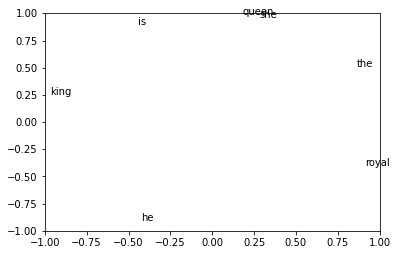

In [18]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.ylim((-1,1))
plt.xlim((-1,1))
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()

In [35]:
# https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model


class WordVecV2(Model):
    def __init__(self, dim, vocab_size):
        super(WordVecV2, self).__init__()
        self.w1 = Dense(dim)
        self.w2 = Dense(vocab_size)

    def call(self, x):
        hidden_representation = self.w1(x)
        logit = self.w2(hidden_representation)
        return logit

model = WordVecV2(5, vocab_size)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')




@tf.function
def train_step(X, labels):

    with tf.GradientTape() as tape:
        
        logits = model(X, training=True)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels, logits, name="softmax_cross_entropy")

        
    gradients = tape.gradient(loss, model.trainable_variables)    
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)


In [36]:
for epoch in range(10):
    # Reset the metrics at the start of the next epoch

    train_loss.reset_states()
    train_accuracy.reset_states()

    train_step(x_train, y_train)
    
    

    if epoch % 1000 == 0:
        print("loss", train_loss.result())
#     print(train_accuracy.result())

[<tf.Tensor 'MatMul_2:0' shape=(7, 5) dtype=float64>, <tf.Tensor 'BiasAddGrad_1:0' shape=(5,) dtype=float64>, <tf.Tensor 'MatMul_1:0' shape=(5, 7) dtype=float64>, <tf.Tensor 'BiasAddGrad:0' shape=(7,) dtype=float64>]
[<tf.Tensor 'MatMul_2:0' shape=(7, 5) dtype=float64>, <tf.Tensor 'BiasAddGrad_1:0' shape=(5,) dtype=float64>, <tf.Tensor 'MatMul_1:0' shape=(5, 7) dtype=float64>, <tf.Tensor 'BiasAddGrad:0' shape=(7,) dtype=float64>]
loss tf.Tensor(2.0197433839938213, shape=(), dtype=float64)


In [30]:
w1 = model.trainable_variables[0].numpy()
b1 = model.trainable_variables[1].numpy()
w2 = model.trainable_variables[2].numpy()
b2 = model.trainable_variables[3].numpy()
vectors = (w1+b1+ (w2+b2).T)/2

is 0.89717036
king 0.25030422
she 0.96019673
the 0.5068005
he -0.9047838
queen 0.9838481
royal -0.4028841


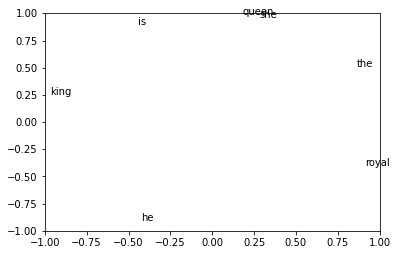

In [33]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.ylim((-1,1))
plt.xlim((-1,1))
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()

In [34]:
pairwise_distances(vectors, vectors)

array([[0.        , 0.83403826, 0.7237585 , 1.3609363 , 1.8020235 ,
        0.6267131 , 1.8792062 ],
       [0.83403826, 0.        , 1.4353337 , 1.8481165 , 1.2760538 ,
        1.3616506 , 1.9934692 ],
       [0.7237585 , 1.4353337 , 0.        , 0.7383446 , 1.9938539 ,
        0.10306922, 1.5041249 ],
       [1.3609363 , 1.8481165 , 0.7383446 , 0.        , 1.9108495 ,
        0.8331521 , 0.91123813],
       [1.8020235 , 1.2760538 , 1.9938539 , 1.9108495 , 0.        ,
        1.9831305 , 1.4319609 ],
       [0.6267131 , 1.3616506 , 0.10306922, 0.8331521 , 1.9831305 ,
        0.        , 1.5700583 ],
       [1.8792062 , 1.9934692 , 1.5041249 , 0.91123813, 1.4319609 ,
        1.5700583 , 0.        ]], dtype=float32)